In [1]:
# Only execute once
assert "changed_cwd" not in locals()
changed_cwd = False

In [2]:
import numpy as np
import torch
import igl
from meshplot import plot, subplot
import imageio
import trimesh
import scipy as sp
import os
import matplotlib.pyplot as plt
%matplotlib widget

import scipy.io

if not changed_cwd:
    changed_cwd = True
    # Set working directory of this notebook to the parent directory of the "texture_transfer" directory
    os.chdir(os.path.split(os.getcwd())[0])

from model import make_model
from utils import load_trained_model, load_cameras
from mesh import load_mesh, compute_first_k_eigenfunctions, load_first_k_eigenfunctions
from renderer import Renderer
from config import load_config

In [3]:
device = "cuda"

EXPERIMENT_PATH = "out/texture_transfer_source/orig_cat"
config = load_config(os.path.join(EXPERIMENT_PATH, "config.yaml"))
k = config["model"]["k"]

print(f"k = {k}")
if isinstance(k, list):
    print(f"number of eigenfunctions = {len(k)}")

camera_views_path = "data/texture_transfer/texture_transfer_cam_poses_cat_dense/cameras.npz"
cameras = np.load(camera_views_path)
print([key for key in cameras.keys()])

# Load trained model
model = load_trained_model(config["model"], os.path.join(config["training"]["out_dir"], "model.pt"), device)
model = model.eval()

k = 512
['world_mat_0', 'camera_mat_0']


# Original Cat

In [4]:
H, W = 512, 512

# Mesh
orig_mesh_path = "data/cat_rescaled_rotated/12221_Cat_v1_l3.obj"
orig_mesh = load_mesh(orig_mesh_path)

# Eigenfunctions
print(config["data"]["eigenfunctions_path"])
orig_eigenfunctions = load_first_k_eigenfunctions(config["data"]["eigenfunctions_path"], k)

E_orig_rescaled = orig_eigenfunctions.numpy()
E_orig = load_first_k_eigenfunctions(config["data"]["eigenfunctions_path"], k, rescale_strategy="unscaled").numpy()

# Renderer
orig_renderer = Renderer(model, orig_mesh, orig_eigenfunctions, H=H, W=W, device=device)

def render_view_orig(camera_idx):
    camCv2world = torch.tensor(cameras[f"world_mat_{camera_idx}"], dtype=torch.float32)
    K = torch.tensor(cameras[f"camera_mat_{camera_idx}"], dtype=torch.float32)
    view = orig_renderer.render(camCv2world, K)
    return view

data/texture_transfer/cat_orig_eigenfunctions_cotan_kmax4096_skip_first_efuncs.npy


# Cat Dense

In [5]:
# Mesh
cat_dense_mesh_path = "data/discretizations/cat/dens.ply"
cat_dense_mesh = load_mesh(cat_dense_mesh_path)

M_dense = igl.massmatrix(cat_dense_mesh.vertices, cat_dense_mesh.faces, igl.MASSMATRIX_TYPE_VORONOI)

# Eigenfunctions
E_dense = load_first_k_eigenfunctions("data/preprocessed/cat_dense/eigenfunctions_robust_kmax4096_skip_first_efuncs.npy", k, rescale_strategy="unscaled").numpy()

# Load Functional Map/P2P-Correspondence
fm_path = "data/texture_transfer/cat_orig_2_cat_dense.mat"
mat_orig_2_dense = scipy.io.loadmat(fm_path)
mat_orig_2_dense.keys()

dict_keys(['__header__', '__version__', '__globals__', 'C', 'P', 'X', 'Y'])

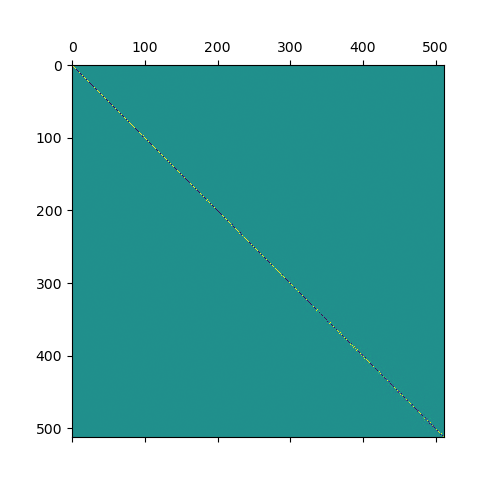

In [6]:
# FM via Point-2-Point Correspondence
num_vertices_orig = E_orig.shape[0]
num_vertices_dense = E_dense.shape[0]

# Build P2P matrix
P = mat_orig_2_dense["P"][0,0][1] - 1
rows = np.arange(0, num_vertices_dense)
data = np.ones(num_vertices_dense, dtype=np.float32)
Q = sp.sparse.csr_matrix((data, (rows, P.reshape(-1))), shape=(num_vertices_dense, num_vertices_orig))

C = E_dense.T @ M_dense @ Q @ E_orig
plt.matshow(C)
mapped_efuncs = E_dense @ C  # n_dense x k_orig

mapped_efuncs /= np.max(mapped_efuncs, axis=0, keepdims=True) - np.min(mapped_efuncs, axis=0, keepdims=True)
mapped_efuncs = torch.from_numpy(mapped_efuncs).to(torch.float32)

E_mapped = mapped_efuncs.numpy()

cat_dense_renderer = Renderer(model, cat_dense_mesh, mapped_efuncs, H=H, W=W, device=device)

def render_view_cat_dense(camera_idx):
    camCv2world = torch.tensor(cameras[f"world_mat_{camera_idx}"], dtype=torch.float32)
    K = torch.tensor(cameras[f"camera_mat_{camera_idx}"], dtype=torch.float32)
    view = cat_dense_renderer.render(camCv2world, K)
    return view

In [7]:
# Mapped eigenfunctions comparison
k_idx = 0

print(f"k_idx = {k_idx}")
p = subplot(cat_dense_mesh.vertices, cat_dense_mesh.faces, c=E_mapped[:, k_idx], s=[1,2,0])
subplot(orig_mesh.vertices, orig_mesh.faces, c=E_orig[:, k_idx], s=[1,2,1], data=p)

k_idx = 0


/usr/stud/grittner/miniconda3/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "uint32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))
/usr/stud/grittner/miniconda3/envs/py36/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float32" does not match required type "float64". A coerced copy has been created.
  np.dtype(self.dtype).name))


In [8]:
def render(idx):
    fig, axs = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

    view_orig = render_view_orig(idx)
    axs[0].imshow(view_orig)
    axs[0].title.set_text("Orig")
    axs[0].axis("off")
    
    view_dense = render_view_cat_dense(idx)
    axs[1].imshow(view_dense)
    axs[1].title.set_text("Dense")
    axs[1].axis("off")

# Camera View 1

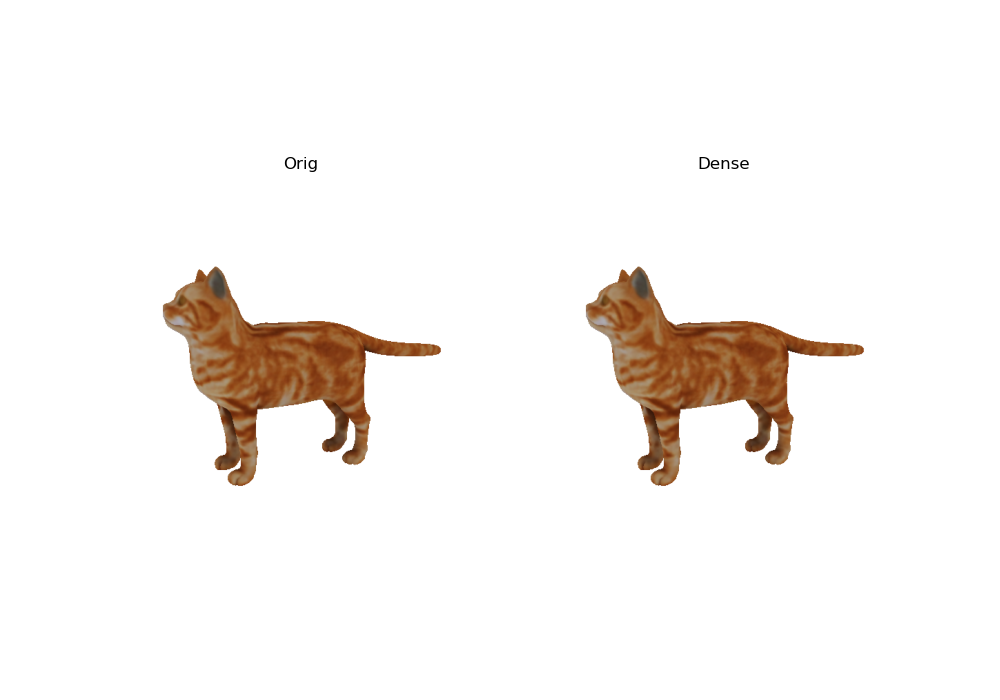

In [9]:
render(0)